# Arbolado IA
-------

### Paquetes
---

In [ ]:
# General
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

# sklearn & XGB
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost import XGBClassifier



# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit

### Carga de datos
----

In [2]:
# Carga de datos
df1 = pd.read_csv('./data-arbolado-junior.csv')
df1 = df1.drop(columns=['id'])
df2 = pd.read_csv('./data-arbolado-crisol.csv')
df3 = pd.read_csv('./data-arbolado-gralpaz.csv')

df = pd.concat([df1, df2, df3])

In [3]:
print("El tamaño del DataFrame es: \n")
print(f'Shape: {df.shape}')

df.head()

El tamaño del DataFrame es: 

Shape: (7970, 28)


,fecha,latitud,longitud,direccion,barrioNombre,altura,fuste,faseVital,estadoFitosanitario,inclinacion,...,intervenciones,distForestalAdecuada,interf,cazuela,levantamientoVereda,observaciones,especieNombre,lugarRelevamientoNombre,tipoLugarNombre,Observaciones
0,7/2/2018,-31.418802,-64.170274,906,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Inadecuada,Leve,NaN,Palmera Pindó,Americo Vespucio 900-1000,Calle,NaN
1,7/2/2018,-31.418807,-64.170212,916,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Regular,Leve,...,Mantenimiento,True,True,Adecuada,Leve,NaN,Siempre Verde,Americo Vespucio 900-1000,Calle,NaN
2,7/2/2018,-31.418807,-64.170161,924,Juniors,Menor a 4m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Crespón,Americo Vespucio 900-1000,Calle,NaN
3,7/2/2018,-31.418832,-64.170114,930,Juniors,Entre 7m. y 10m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,Leve,...,Mantenimiento,True,False,Franja Verde,No,NaN,Guaran Amarillo,Americo Vespucio 900-1000,Calle,NaN
4,7/2/2018,-31.418868,-64.169999,932,Juniors,Menor a 4m.,"Menor a 0,10m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Ficus Benjamina,Americo Vespucio 900-1000,Calle,NaN


## Ingeniería de Datos
----

In [4]:
cols_to_drop = [
    "fecha", "latitud", "longitud", "direccion", 
    "barrioNombre", "observaciones", "lugarRelevamientoNombre", 
    "tipoLugarNombre", "Observaciones"
]
df = df.drop(columns=cols_to_drop)

In [5]:
print(df.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio', 'problemaGrieta',
       'problemaDesequilibrioCopa', 'manejoInadecuado', 'intervenciones',
       'distForestalAdecuada', 'interf', 'cazuela', 'levantamientoVereda',
       'especieNombre'],
      dtype='object')


### DataFrame discreto
---

In [6]:
filas_con_nan = df.isna().any(axis=1)

# Cantidad de filas con al menos un dato vacío
print(f"Filas con al menos un NaN: {filas_con_nan.sum()}")

# Filtrar esas filas
df = df[~df.isna().any(axis=1)].copy()

Filas con al menos un NaN: 978


In [7]:
label_maps = {}

le = LabelEncoder()

for col in df.columns:
    # Ignora columnas completamente vacías
    if df[col].dropna().empty:
        continue

    first_val = df[col].dropna().iloc[0]

    # Columnas booleanas (True/False)
    if isinstance(first_val, bool):
        df[col] = df[col].astype('boolean').fillna(False).astype(int)
    
    elif col == 'especieNombre' or col == 'cazuela':
        df[col] = le.fit_transform(df[col].astype(str))


In [8]:
# Diccionarios de remapeo
altura_map = {
    'Menor a 4m.': 0,
    'Entre 4m. y 7m.': 1,
    'Entre 7m. y 10m.': 2,
    'Mayor a 10m': 3
}

fuste_map = {
    'Menor a 0,10m.': 0,
    'Entre 0,10m. y 0,40m.': 1,
    'Mayor 0,40m': 2,
}

estadoFitosanitario_map = {
    'Bueno': 0,
    'Regular': 1,
    'Malo': 2,
    'Muerto': 3
}

leve_no_severa_map = {
    'No': 0,
    'Leve': 1,
    'Severa': 2
}

intervenciones_map = {
    'Sin intervenciones': 0,
    'Descopado': 1,
    'Despunte': 2,
    'Mantenimiento': 3,
    'Raíces': 4,
    'Tala': 5,
    'Varias intervenciones': 6
}

levantamientoVereda_map = {
    'No': 0,
    'Leve': 1,
    'Considerable': 2,
}

faseVital_map = {
    "Recién implantado": 0,
    "Joven": 1,
    "Maduro": 2,
    "Añoso": 3,
    "Decrépito": 4
}

# Aplicar remapeos en df
df['altura'] = df['altura'].map(altura_map)
df['fuste'] = df['fuste'].map(fuste_map)
df['estadoFitosanitario'] = df['estadoFitosanitario'].map(estadoFitosanitario_map)

# Columnas que comparten clasificación
for col in ['inclinacion', 'ahuecamiento', 'manejoInadecuado']:
    df[col] = df[col].map(leve_no_severa_map)

df['intervenciones'] = df['intervenciones'].map(intervenciones_map)
df['levantamientoVereda'] = df['levantamientoVereda'].map(levantamientoVereda_map)
df['faseVital'] = df['faseVital'].map(faseVital_map)

# Actualizar label_maps
label_maps.update({
    'altura': altura_map,
    'fuste': fuste_map,
    'estadoFitosanitario': estadoFitosanitario_map,
    'inclinacion': leve_no_severa_map,
    'ahuecamiento': leve_no_severa_map,
    'manejoInadecuado': leve_no_severa_map,
    'intervenciones': intervenciones_map,
    'levantamientoVereda': levantamientoVereda_map,
    'faseVital': faseVital_map
})


In [18]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    5427
0    1142
2     330
3      93
Name: count, dtype: int64

### DataFrame continuo
----

In [9]:
# Copiar el DataFrame original codificado
df_cont = df.copy()

# Quitar columna de especies
#df_cont = df_cont.drop(columns=['especieNombre'])

# One-hot encoding solo de la columna especieNombre
df_cont = pd.get_dummies(df_cont, columns=['especieNombre'])

# Inicializar el scaler
scaler = MinMaxScaler()

# Ajustar y transformar todas las columnas (o solo las que quieres escalar)
df_cont[df_cont.columns] = scaler.fit_transform(df_cont[df_cont.columns])

In [14]:
print(df_cont.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio',
       ...
       'especieNombre_89', 'especieNombre_90', 'especieNombre_91',
       'especieNombre_92', 'especieNombre_93', 'especieNombre_94',
       'especieNombre_95', 'especieNombre_96', 'especieNombre_97',
       'especieNombre_98'],
      dtype='object', length=117)


## Entrenamiento
----

### XGBoost - Regressor 
---

In [105]:
# Features (todas menos la columna objetivo)
X_XGB = df_cont.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea numérico)
y_XGB = df_cont["estadoFitosanitario"].astype(float)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_XGB, y_XGB, test_size=0.2, random_state=42
)

# Definir modelo XGBoost para regresión
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_reg.fit(X_train, y_train)

# Predecir
y_pred = xgb_reg.predict(X_test)

# Evaluar con métricas de regresión
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 0.1420628840357303
R²: 0.2680704168993746


faseVital             0.042451
problemaDesrames      0.028943
manejoInadecuado      0.026872
especieNombre_70      0.023651
problemaDescalzado    0.021992
                        ...   
especieNombre_51      0.000000
especieNombre_81      0.000000
especieNombre_69      0.000000
especieNombre_83      0.000000
especieNombre_92      0.000000
Length: 116, dtype: float32


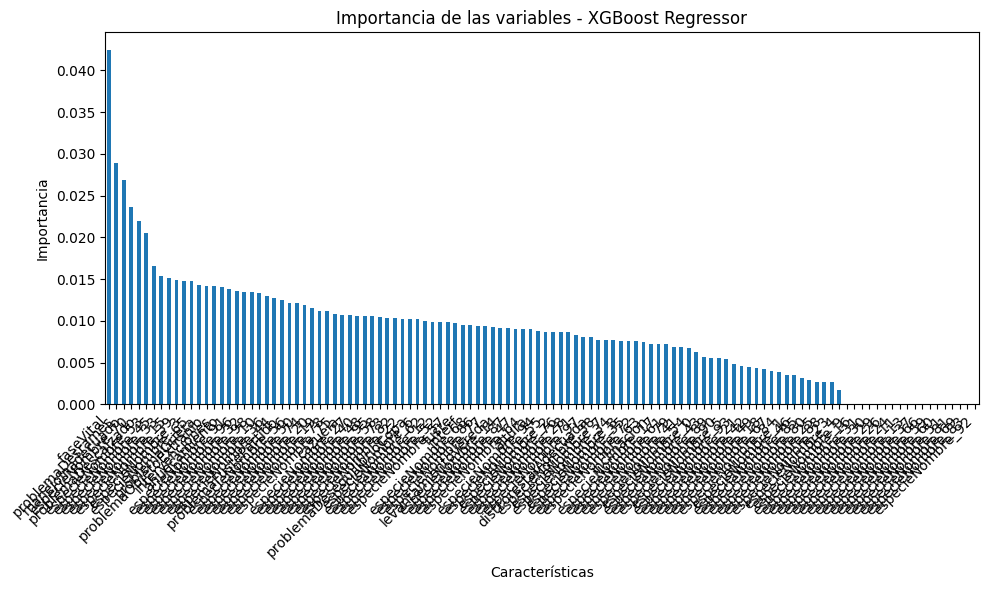

In [106]:
# Suponiendo que tu modelo se llama xgb_reg y tu DataFrame X
feature_importances = pd.Series(
    xgb_reg.feature_importances_,
    index=X_XGB.columns
).sort_values(ascending=False)

# Mostrar importancia
print(feature_importances)

# Gráfico de barras
plt.figure(figsize=(10,6))
feature_importances.plot(kind='bar')
plt.title("Importancia de las variables - XGBoost Regressor")
plt.ylabel("Importancia")
plt.xlabel("Características")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [107]:
# Lista de columnas a eliminar
cols_a_eliminar = ["cazuela", "problemaGrieta", "inclinacion", "distForestalAdecuada", "levantamientoVereda",  "problemaDesequilibrioCopa", "interf"]

# Crear un nuevo DataFrame solo con las columnas más importantes
df_reducido = df_cont.drop(columns=cols_a_eliminar)


In [108]:
# Features (todas menos la columna objetivo)
X = df_reducido.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea numérico)
y = df_reducido["estadoFitosanitario"].astype(float)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir modelo XGBoost para regresión
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_reg.fit(X_train, y_train)

# Predecir
y_pred = xgb_reg.predict(X_test)

# Evaluar con métricas de regresión
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 0.14244117838723303
R²: 0.2641671668366713


### XGBoost - Classifier
---

Accuracy: 0.8084345961401

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       228
           1       0.85      0.93      0.89      1086
           2       0.38      0.14      0.20        66
           3       0.55      0.32      0.40        19

    accuracy                           0.81      1399
   macro avg       0.60      0.46      0.50      1399
weighted avg       0.78      0.81      0.79      1399



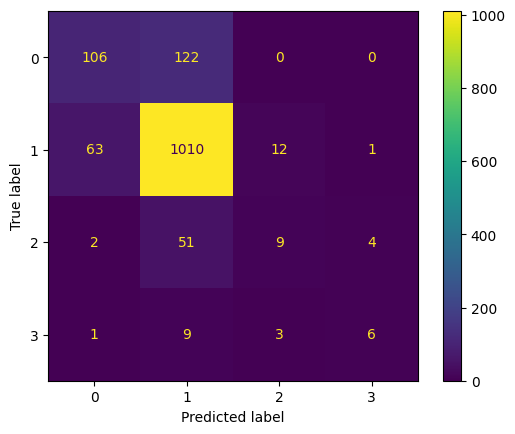

In [24]:
# Features (todas menos la columna objetivo)
X = df.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea entero)
y = df["estadoFitosanitario"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo XGBoost para clasificación
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_clf.fit(X_train, y_train)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()


Para solventar el desbalanceo de clases que tienen los datos, primero vamos a optar por submuestreo de las clases mayoritarias, es este caso `Regualar` y `Bueno`

Accuracy: 0.8120085775553967

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58       228
           1       0.86      0.91      0.89      1086
           2       0.41      0.24      0.30        66
           3       0.80      0.21      0.33        19

    accuracy                           0.81      1399
   macro avg       0.67      0.48      0.53      1399
weighted avg       0.80      0.81      0.80      1399



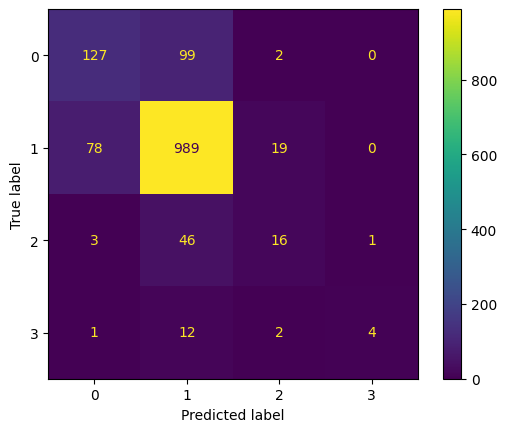

In [45]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)

# ---- Balancear SOLO el conjunto de entrenamiento ----
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# ---- Definir y entrenar modelo ----
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

xgb_clf.fit(X_train_res, y_train_res)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

Accuracy: 0.7676912080057183

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.46      0.54       228
           1       0.86      0.86      0.86      1086
           2       0.19      0.32      0.24        66
           3       0.26      0.47      0.33        19

    accuracy                           0.77      1399
   macro avg       0.49      0.53      0.49      1399
weighted avg       0.79      0.77      0.77      1399



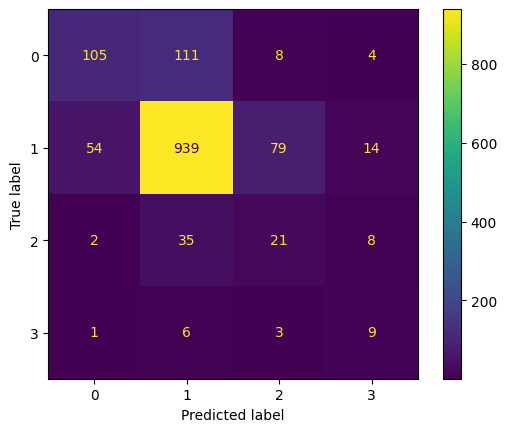

In [48]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0,1,2,3])
disp_pre.plot()

### Random Forest Regressor
---

In [25]:
X_rf = df_cont.drop("estadoFitosanitario", axis=1)
y_rf = df_cont["estadoFitosanitario"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(
    n_estimators=300,   # número de árboles
    max_depth=None,     # profundidad máxima de los árboles
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest Regressor")
print("RMSE:", rmse)
print("R²:", r2)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Random Foresft - Classifier
---

In [26]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train, y_train)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Decision Tree Classifier
---

In [27]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train, y_train)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Prueba del modelo - Datos Artificiales
-----

In [27]:
# Features (todas menos la columna objetivo)
X = df1.drop("faseVital", axis=1)

# Target (asegurarse de que sea numérico)
y = df1["faseVital"].astype(float)

NameError: name 'df1' is not defined

In [ ]:
# Número de datos sintéticos que querés generar
n_samples = 100

synthetic_data = pd.DataFrame()

for col in X.columns:  # X = df1.drop("faseVital", axis=1)
    if X[col].dtype == float or X[col].dtype == int:
        # Generamos valores aleatorios normales con la misma media y desviación
        mu = X[col].mean()
        sigma = X[col].std()
        synthetic_data[col] = np.random.normal(mu, sigma, n_samples).round()
    else:
        # Para columnas categóricas, muestreamos los valores existentes
        synthetic_data[col] = np.random.choice(X[col], size=n_samples, replace=True)


### XGBoost
---

In [ ]:
# Predecir usando el modelo XGBoost ya entrenado
y_pred_synthetic = xgb_reg.predict(synthetic_data)

# Si querés mapear a los valores discretos de faseVital (0–4):
y_pred_synthetic_rounded = np.clip(np.round(y_pred_synthetic), 0, 4).astype(int)

print(y_pred_synthetic_rounded)

[2 2 2 1 2 2 3 2 2 2 2 2 1 3 2 1 2 2 2 2 3 2 2 2 2 2 2 2 2 3 2 1 2 3 2 3 3
 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 1 1 3 2 2 2 2 2 4 2 2 2 3 2 2 2 2 2 2 2 2
 3 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
# Invertir el label map para faseVital
fase_map_invertido = {v: k for k, v in label_maps['faseVital'].items()}

# Iterar sobre las predicciones y mostrar el mensaje
for i, pred in enumerate(y_pred_synthetic_rounded, 1):  # empezamos la numeración en 1
    fase = fase_map_invertido[pred]
    print(f"La muestra {i} está en fase {fase}")


La muestra 1 está en fase Maduro
La muestra 2 está en fase Maduro
La muestra 3 está en fase Maduro
La muestra 4 está en fase Joven
La muestra 5 está en fase Maduro
La muestra 6 está en fase Maduro
La muestra 7 está en fase Añoso
La muestra 8 está en fase Maduro
La muestra 9 está en fase Maduro
La muestra 10 está en fase Maduro
La muestra 11 está en fase Maduro
La muestra 12 está en fase Maduro
La muestra 13 está en fase Joven
La muestra 14 está en fase Añoso
La muestra 15 está en fase Maduro
La muestra 16 está en fase Joven
La muestra 17 está en fase Maduro
La muestra 18 está en fase Maduro
La muestra 19 está en fase Maduro
La muestra 20 está en fase Maduro
La muestra 21 está en fase Añoso
La muestra 22 está en fase Maduro
La muestra 23 está en fase Maduro
La muestra 24 está en fase Maduro
La muestra 25 está en fase Maduro
La muestra 26 está en fase Maduro
La muestra 27 está en fase Maduro
La muestra 28 está en fase Maduro
La muestra 29 está en fase Maduro
La muestra 30 está en fase Añ